<a href="https://colab.research.google.com/github/santyxd3000/Undergraduate-Project/blob/main/Classifying_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO DE GRADO - MODELOS DE CLASIFICACIÓN**

Santiago Pardo Morales - 202013025

In [1]:
#For using the GPU
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 438, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 438 (delta 121), reused 57 (delta 54), pack-reused 269
Receiving objects: 100% (438/438), 118.31 KiB | 5.14 MiB/s, done.
Resolving deltas: 100% (223/223), done.
***********************************************************************
We will now install RAPIDS via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 955.2/955.2 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.8/142.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import datetime
import scipy
sns.set()
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import io
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterGrid
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import cudf
import cuml
import cupy as cp
from cuml import preprocessing as cpp
import tensorflow as tf
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
physical_devices = tf.config.list_physical_devices('GPU')
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import NearMiss
from cuml.svm import SVC
from cuml.multiclass import OneVsOneClassifier
from cuml.multiclass import OneVsRestClassifier

In [3]:
from collections import Counter

In [4]:
print("GPU:", tf.config.list_physical_devices('GPU'))
print("Num GPUs:", len(physical_devices))

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs: 1


In [5]:
#Leer datos etiquetados
df = pd.read_csv('df_with_labels_ae11.csv',sep=';').dropna()

In [6]:
#Counting each item
print(sorted(Counter(df['Label']).items()))

[('No Fault', 103345), ('Open Circuit', 976), ('Shading', 44407), ('Short Circuit', 1602), ('Unknown', 68)]


In [7]:
#Time series
train_data = df[df['Timestamp']<='2021-09-03']
print(sorted(Counter(train_data['Label']).items()))

[('No Fault', 94713), ('Open Circuit', 970), ('Shading', 5007), ('Short Circuit', 1483), ('Unknown', 63)]


In [8]:
val_test_data = df[df['Timestamp']>='2021-09-03']

In [9]:
#Time series
val_data = val_test_data[val_test_data['Timestamp']<='2022-05-16']
print(sorted(Counter(val_data['Label']).items()))

[('No Fault', 159), ('Open Circuit', 5), ('Shading', 23799)]


In [10]:
#Time series
test_data = val_test_data[val_test_data['Timestamp']>='2022-05-16']
print(sorted(Counter(test_data['Label']).items()))

[('No Fault', 8473), ('Open Circuit', 1), ('Shading', 15601), ('Short Circuit', 119), ('Unknown', 5)]


## **MÉTODO 1 - RED NEURONAL**

In [11]:
df['Label'].replace({'No Fault': 0, 'Shading': 1, 'Open Circuit': 2, 'Short Circuit': 3, 'Unknown':4}, inplace=True)

In [12]:
df[df['Label']==1].shape

(44407, 6)

In [13]:
x_data = df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = df[['Label']]

In [14]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_data)
y_data = np.array(y_data)

In [15]:
#Divide data
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

### Red Neuronal - Solo capa de entrada y de salida

In [16]:
ann_1 = Sequential()
ann_1.add(Dense(4, input_shape=(x_train.shape[1],),activation='relu'))

#output layer with softmax function
ann_1.add(Dense(5,activation='softmax'))

#compile model
ann_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [17]:
history= ann_1.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_1.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.4272 - accuracy: 0.8875 - val_loss: 0.1760 - val_accuracy: 0.9423
Epoch 2/100
2820/2820 [==============================] - 10s 4ms/step - loss: 0.1328 - accuracy: 0.9532 - val_loss: 0.1009 - val_accuracy: 0.9663
Epoch 3/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0894 - accuracy: 0.9688 - val_loss: 0.0821 - val_accuracy: 0.9688
Epoch 4/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.0771 - accuracy: 0.9705 - val_loss: 0.0735 - val_accuracy: 0.9701
Epoch 5/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0702 - accuracy: 0.9717 - val_loss: 0.0680 - val_accuracy: 0.9696
Epoch 6/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0651 - accuracy: 0.9727 - val_loss: 0.0631 - val_accuracy: 0.9718
Epoch 7/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0612 - accuracy: 0.9735 - val_loss: 0.0601 -

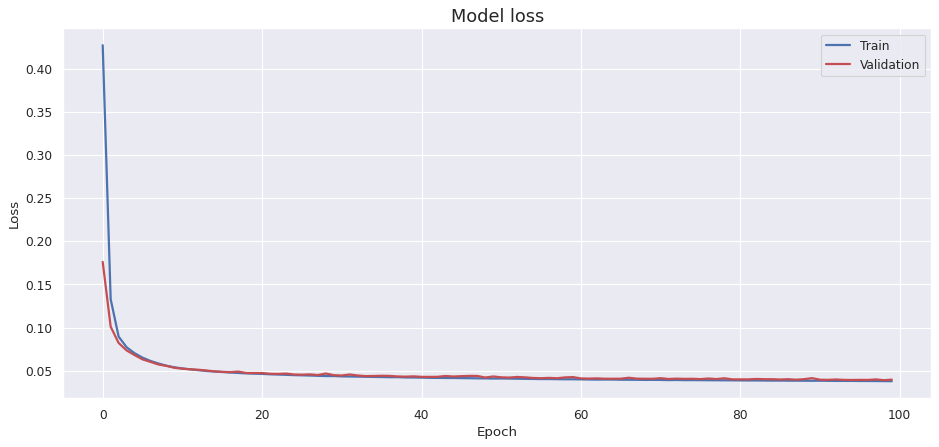

In [18]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - Capa intermedia entre entrada y salida

In [19]:
ann_2 = Sequential()
ann_2.add(Dense(16, input_shape=(x_train.shape[1],),activation='relu'))
ann_2.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_2.add(Dense(5,activation='softmax'))

#compile model
ann_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [20]:
history= ann_2.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_2.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 13s 4ms/step - loss: 0.2448 - accuracy: 0.9324 - val_loss: 0.1074 - val_accuracy: 0.9602
Epoch 2/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0777 - accuracy: 0.9726 - val_loss: 0.0677 - val_accuracy: 0.9744
Epoch 3/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0576 - accuracy: 0.9785 - val_loss: 0.0553 - val_accuracy: 0.9811
Epoch 4/100
2820/2820 [==============================] - 11s 4ms/step - loss: 0.0506 - accuracy: 0.9815 - val_loss: 0.0497 - val_accuracy: 0.9787
Epoch 5/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0466 - accuracy: 0.9826 - val_loss: 0.0457 - val_accuracy: 0.9864
Epoch 6/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0437 - accuracy: 0.9837 - val_loss: 0.0441 - val_accuracy: 0.9844
Epoch 7/100
2820/2820 [==============================] - 12s 4ms/step - loss: 0.0417 - accuracy: 0.9843 - val_loss: 0.0438 -

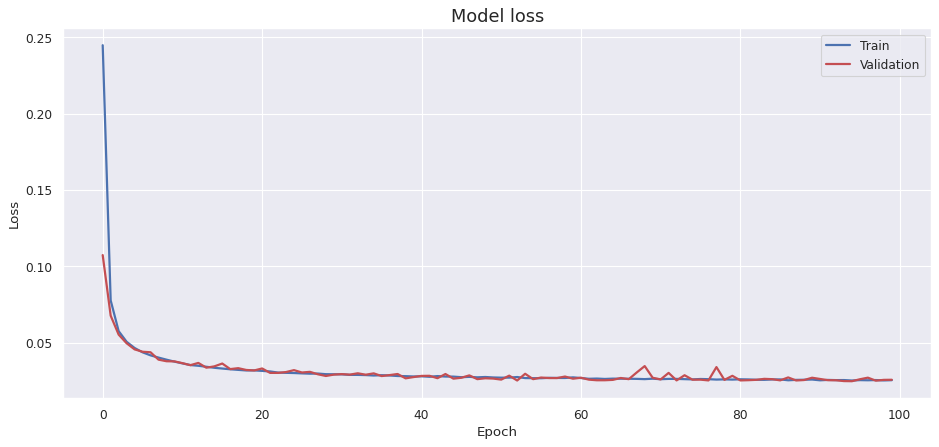

In [21]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 2 capas intermedia entre entrada y salida

In [22]:
ann_3 = Sequential()
ann_3.add(Dense(64, input_shape=(x_train.shape[1],),activation='relu'))
ann_3.add(Dense(16 ,activation='relu'))
ann_3.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_3.add(Dense(5,activation='softmax'))

#compile model
ann_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [23]:
history= ann_3.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_3.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 16s 5ms/step - loss: 0.2239 - accuracy: 0.9633 - val_loss: 0.0604 - val_accuracy: 0.9753
Epoch 2/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0501 - accuracy: 0.9815 - val_loss: 0.0523 - val_accuracy: 0.9758
Epoch 3/100
2820/2820 [==============================] - 13s 5ms/step - loss: 0.0433 - accuracy: 0.9821 - val_loss: 0.0410 - val_accuracy: 0.9837
Epoch 4/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0392 - accuracy: 0.9837 - val_loss: 0.0407 - val_accuracy: 0.9836
Epoch 5/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0374 - accuracy: 0.9840 - val_loss: 0.0372 - val_accuracy: 0.9849
Epoch 6/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0358 - accuracy: 0.9845 - val_loss: 0.0322 - val_accuracy: 0.9887
Epoch 7/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0346 - accuracy: 0.9851 - val_loss: 0.0364 -

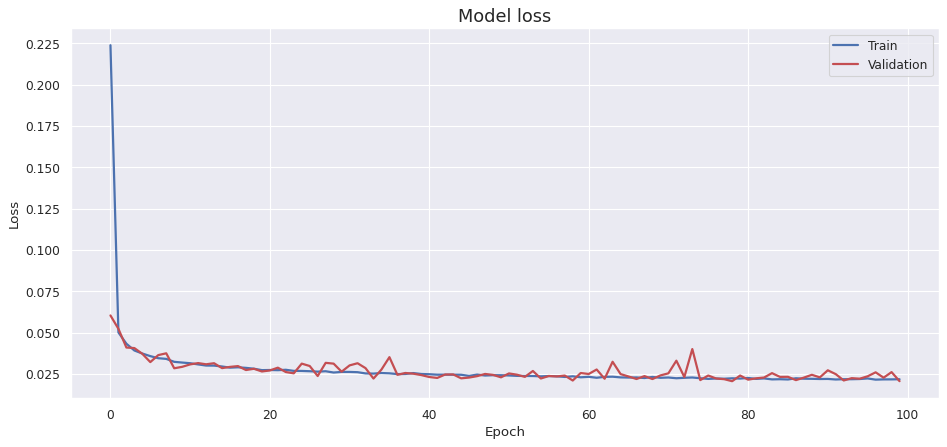

In [24]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 3 capas intermedia entre entrada y salida

In [25]:
ann_4 = Sequential()
ann_4.add(Dense(256, input_shape=(x_train.shape[1],),activation='relu'))
ann_4.add(Dense(64 ,activation='relu'))
ann_4.add(Dense(16 ,activation='relu'))
ann_4.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_4.add(Dense(5,activation='softmax'))

#compile model
ann_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [26]:
history= ann_4.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_4.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 16s 5ms/step - loss: 0.1368 - accuracy: 0.9617 - val_loss: 0.0790 - val_accuracy: 0.9703
Epoch 2/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0800 - accuracy: 0.9681 - val_loss: 0.0791 - val_accuracy: 0.9694
Epoch 3/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0747 - accuracy: 0.9696 - val_loss: 0.0760 - val_accuracy: 0.9672
Epoch 4/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0723 - accuracy: 0.9702 - val_loss: 0.0711 - val_accuracy: 0.9704
Epoch 5/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0636 - accuracy: 0.9734 - val_loss: 0.0638 - val_accuracy: 0.9754
Epoch 6/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0531 - accuracy: 0.9793 - val_loss: 0.0469 - val_accuracy: 0.9821
Epoch 7/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0474 - accuracy: 0.9813 - val_loss: 0.0427 -

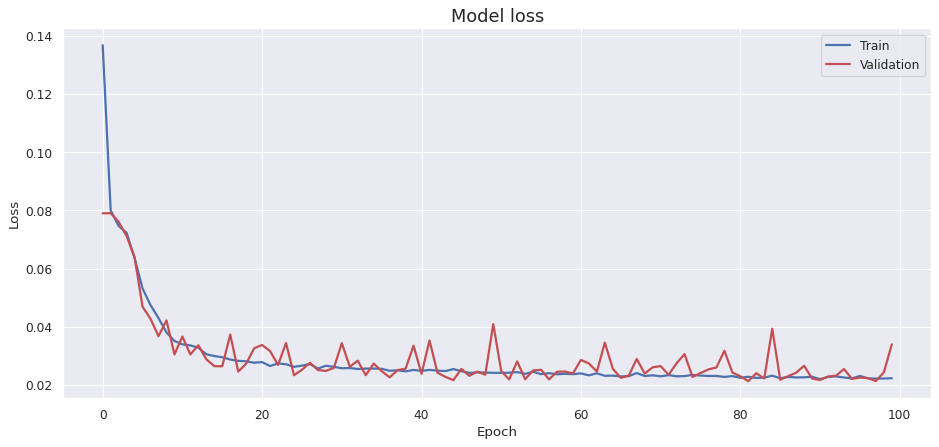

In [27]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Red Neuronal - 4 capas intermedia entre entrada y salida

In [28]:
ann_5 = Sequential()
ann_5.add(Dense(1024, input_shape=(x_train.shape[1],),activation='relu'))
ann_5.add(Dense(256 ,activation='relu'))
ann_5.add(Dense(64 ,activation='relu'))
ann_5.add(Dense(16 ,activation='relu'))
ann_5.add(Dense(4 ,activation='relu'))
#output layer with softmax function
ann_5.add(Dense(5,activation='softmax'))

#compile model
ann_5.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [29]:
history= ann_5.fit(x_train,y_train, validation_data=(x_val,y_val),epochs=100, batch_size=32)
loss, accuracy= ann_5.evaluate(x_val,y_val)
print('Accuracy:', accuracy)
print('\nLoss:',loss)

Epoch 1/100
2820/2820 [==============================] - 17s 5ms/step - loss: 0.1573 - accuracy: 0.9431 - val_loss: 0.0566 - val_accuracy: 0.9720
Epoch 2/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0543 - accuracy: 0.9800 - val_loss: 0.0414 - val_accuracy: 0.9859
Epoch 3/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0453 - accuracy: 0.9826 - val_loss: 0.0463 - val_accuracy: 0.9817
Epoch 4/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0421 - accuracy: 0.9838 - val_loss: 0.0478 - val_accuracy: 0.9805
Epoch 5/100
2820/2820 [==============================] - 14s 5ms/step - loss: 0.0398 - accuracy: 0.9839 - val_loss: 0.0329 - val_accuracy: 0.9875
Epoch 6/100
2820/2820 [==============================] - 16s 6ms/step - loss: 0.0380 - accuracy: 0.9852 - val_loss: 0.0430 - val_accuracy: 0.9845
Epoch 7/100
2820/2820 [==============================] - 15s 5ms/step - loss: 0.0353 - accuracy: 0.9853 - val_loss: 0.0419 -

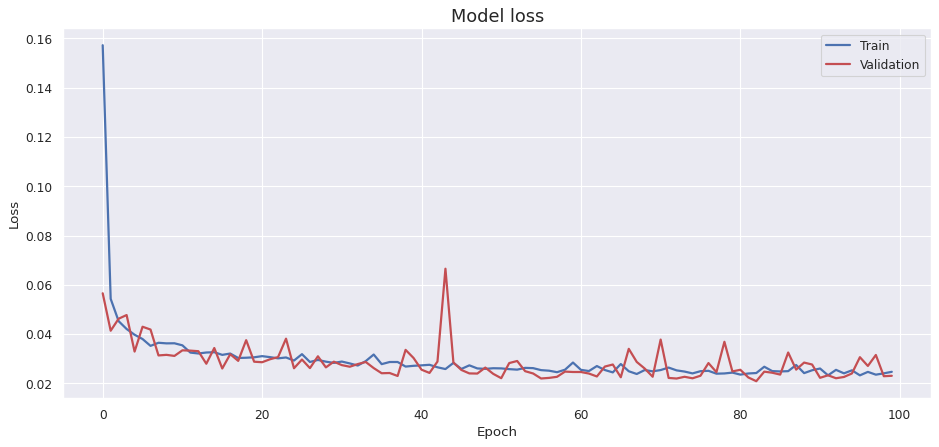

In [30]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history.history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history.history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

### Modelo Escogido - Red Neuronal con 2 capas intermedias entre entrada y salida

In [31]:
ann_predict_test = ann_2.predict(x_test)

940/940 [==============================] - 2s 2ms/step


In [32]:
ann_predict_test = np.argmax(ann_predict_test, axis=1)

Text(0.5, 1.0, 'Confusion Matrix for ANN - Test Data')

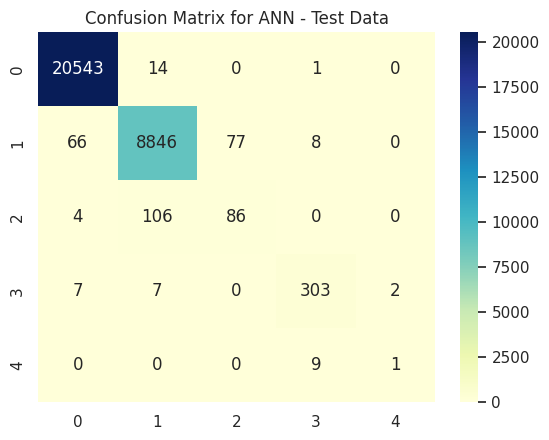

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(y_test, ann_predict_test)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for ANN - Test Data')

In [34]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, ann_predict_test)
precision = precision_score(y_test, ann_predict_test,average='macro')
recall = recall_score(y_test, ann_predict_test,average='macro')
f1_score = f1_score(y_test, ann_predict_test,average='macro')

In [35]:
print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9899933510638298
Precision: 0.757395623702299
Recall: 0.6942211510391204
F1-Score: 0.7124250716111985


## **MÉTODO 2 - SUPPORT VECTOR MACHINES**

In [36]:
cu_df = cudf.DataFrame(df)

In [37]:
x_data = cu_df[['U_DC1','U_DC2','I_DC1','I_DC2']]
y_data = cu_df[['Label']]

In [38]:
cu_scaler = cuml.preprocessing.StandardScaler()
x_scaled = cu_scaler.fit_transform(x_data)
y_data = y_data.to_cupy()

In [39]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled, y_data, train_size = 0.6, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size = 0.5, random_state=42)

x_train = x_train.to_numpy()
y_train = y_train.ravel()
y_train = cp.asnumpy(y_train)
x_val = x_val.to_numpy()
y_val = y_val.ravel()
y_val = cp.asnumpy(y_val)
x_test = x_test.to_numpy()
y_test = y_test.ravel()
y_test = cp.asnumpy(y_test)

In [40]:
"""svc_classifier = SVC(kernel='rbf',gamma='scale',decision_function_shape='ovr',random_state=42)

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'rbf\',gamma=\'scale\',decision_function_shape=\'ovr\',random_state=42)\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs Rest Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)'

In [41]:
best_svm_1 = OneVsRestClassifier(SVC(kernel='rbf',gamma='scale',random_state=42,C=1000))
best_svm_1.fit(x_train,y_train)
best_svm_1_val_pred = best_svm_1.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

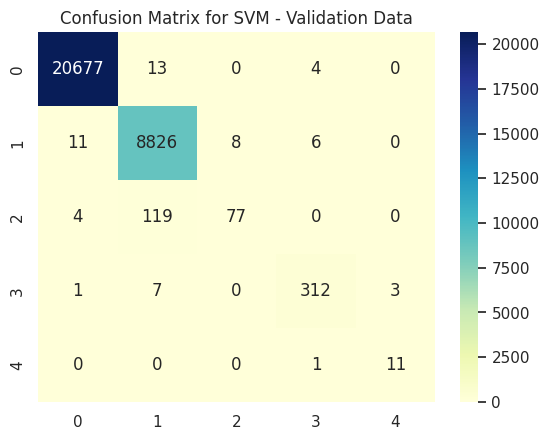

In [42]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_1_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [43]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_1_val_pred)
precision = precision_score(y_val, best_svm_1_val_pred,average='macro')
recall = recall_score(y_val, best_svm_1_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_1_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9941156914893617
Precision: 0.9282525924223697
Recall: 0.8527929810719094
F1-Score: 0.8684892870332238


In [44]:
"""svc_classifier =SVC(kernel='rbf',gamma='auto',decision_function_shape='ovr',)

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)"""

'svc_classifier =SVC(kernel=\'rbf\',gamma=\'auto\',decision_function_shape=\'ovr\',)\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs Rest Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)'

In [45]:
best_svm_2 = OneVsRestClassifier(SVC(kernel='rbf',gamma='auto',random_state=42,C=1000))
best_svm_2.fit(x_train,y_train)
best_svm_2_val_pred = best_svm_2.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

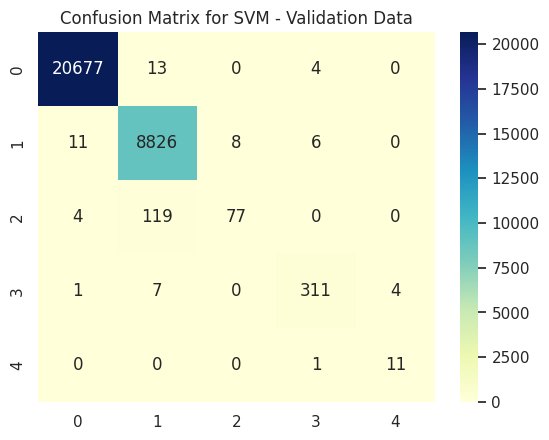

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_2_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [47]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_2_val_pred)
precision = precision_score(y_val, best_svm_2_val_pred,average='macro')
recall = recall_score(y_val, best_svm_2_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_2_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9940824468085107
Precision: 0.917755249320369
Recall: 0.8521737860254698
F1-Score: 0.8619008433305169


In [48]:
"""svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovr')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs Rest Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'sigmoid\',random_state=42,decision_function_shape=\'ovr\')\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs Rest Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)'

In [49]:
best_svm_3 = OneVsRestClassifier(SVC(kernel='sigmoid',random_state=42,C=0.001))
best_svm_3.fit(x_train,y_train)
best_svm_3_val_pred = best_svm_3.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

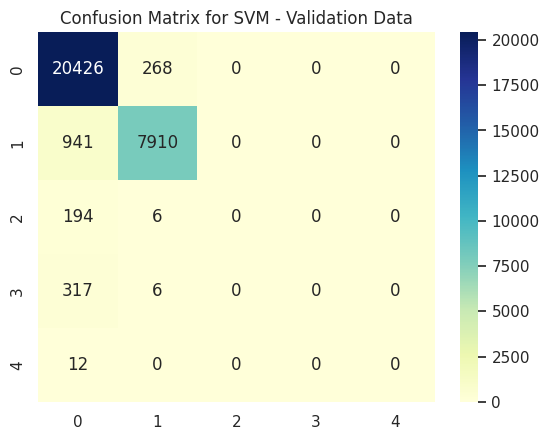

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_3_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_3_val_pred)
precision = precision_score(y_val, best_svm_3_val_pred,average='macro')
recall = recall_score(y_val, best_svm_3_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_3_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9420212765957446
Precision: 0.37978642239948773
Recall: 0.3761467431499687
F1-Score: 0.37753534444113923


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
"""svc_classifier = SVC(kernel='rbf',gamma='scale',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'rbf\',gamma=\'scale\',random_state=42,decision_function_shape=\'ovo\')\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs One Classification and RBF Kernel with Gamma Scale: ", grid_search_ovr.best_params_)'

In [53]:
best_svm_4 = OneVsOneClassifier(SVC(kernel='rbf',gamma='scale',random_state=42,C=1000))
best_svm_4.fit(x_train,y_train)
best_svm_4_val_pred = best_svm_4.predict(x_val)

[W] [23:25:37.583517] Warning: could not fill working set, found only 836 elements


Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

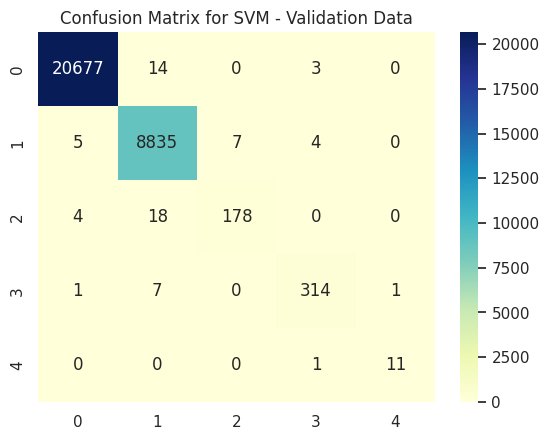

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_4_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [55]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_4_val_pred)
precision = precision_score(y_val, best_svm_4_val_pred,average='macro')
recall = recall_score(y_val, best_svm_4_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_4_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9978390957446809
Precision: 0.9698211703140058
Recall: 0.955234738015992
F1-Score: 0.9622459933838344


In [56]:
"""svc_classifier = SVC(kernel='rbf',gamma='auto',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'rbf\',gamma=\'auto\',random_state=42,decision_function_shape=\'ovo\')\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = cuml.model_selection.GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs One Classification RBF Kernel and Gamma Auto: ", grid_search_ovr.best_params_)'

In [57]:
best_svm_5 = OneVsOneClassifier(SVC(kernel='rbf',gamma='auto',random_state=42,C=1000))
best_svm_5.fit(x_train,y_train)
best_svm_5_val_pred = best_svm_5.predict(x_val)

[W] [23:25:43.197567] Warning: could not fill working set, found only 836 elements


Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

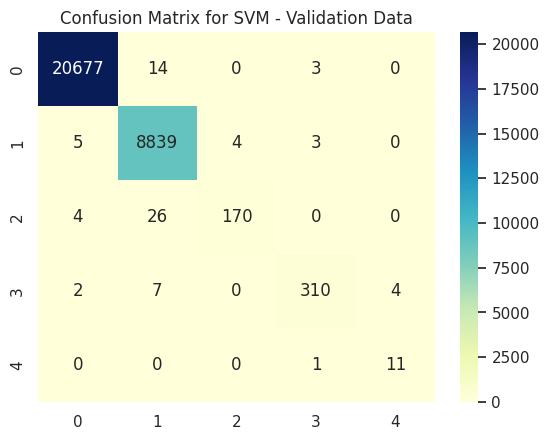

In [58]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_5_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_5_val_pred)
precision = precision_score(y_val, best_svm_5_val_pred,average='macro')
recall = recall_score(y_val, best_svm_5_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_5_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9975731382978723
Precision: 0.9364883760918371
Recall: 0.9448483430974349
F1-Score: 0.9377305442671346


In [60]:
"""svc_classifier = SVC(kernel='sigmoid',random_state=42,decision_function_shape='ovo')

param_grid = {
    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),
}

grid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring='accuracy', cv=5, refit='accuracy',n_jobs=-1)

grid_search_ovr.fit(x_train, y_train)

print("Best Parameters for SVM with One vs One Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)"""

'svc_classifier = SVC(kernel=\'sigmoid\',random_state=42,decision_function_shape=\'ovo\')\n\nparam_grid = {\n    "C": np.array([0.001,0.01,0.1,1,10,100,1000,10000]),\n}\n\ngrid_search_ovr = GridSearchCV(svc_classifier, param_grid, scoring=\'accuracy\', cv=5, refit=\'accuracy\',n_jobs=-1)\n\ngrid_search_ovr.fit(x_train, y_train)\n\nprint("Best Parameters for SVM with One vs One Classification and Sigmoid Kernel: ", grid_search_ovr.best_params_)'

In [61]:
best_svm_6 = OneVsOneClassifier(SVC(kernel='sigmoid',random_state=42,C=0.001))
best_svm_6.fit(x_train,y_train)
best_svm_6_val_pred = best_svm_6.predict(x_val)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Validation Data')

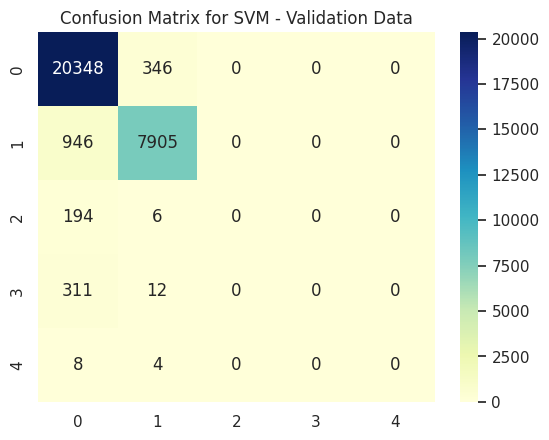

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, best_svm_6_val_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Validation Data')

In [63]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_val, best_svm_6_val_pred)
precision = precision_score(y_val, best_svm_6_val_pred,average='macro')
recall = recall_score(y_val, best_svm_6_val_pred,average='macro')
f1_score = f1_score(y_val, best_svm_6_val_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9392619680851064
Precision: 0.3777225655498457
Recall: 0.37527991987272247
F1-Score: 0.3761592006401037


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*Modelo Escogido - OnevsRest - Kernel RBF - Gamma Scale*

In [64]:
best_svm_1_test_pred = best_svm_1.predict(x_test)

Text(0.5, 1.0, 'Confusion Matrix for SVM - Test Data')

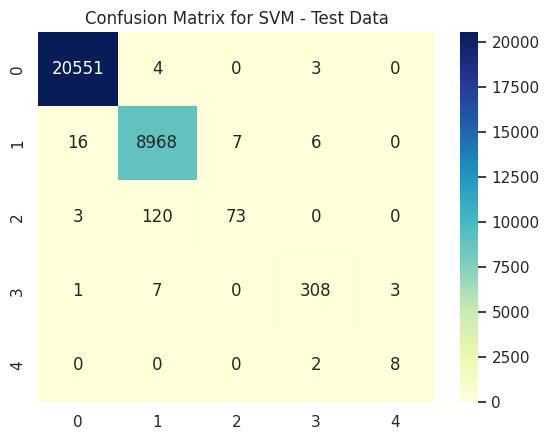

In [65]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, best_svm_1_test_pred)
sns.heatmap(cm,annot=True, fmt='g',cmap='YlGnBu')
plt.title('Confusion Matrix for SVM - Test Data')

In [66]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
accuracy = accuracy_score(y_test, best_svm_1_test_pred)
precision = precision_score(y_test, best_svm_1_test_pred,average='macro')
recall = recall_score(y_test, best_svm_1_test_pred,average='macro')
f1_score = f1_score(y_test, best_svm_1_test_pred,average='macro')

print("Accuracy: "+ str(accuracy))
print("Precision: "+ str(precision))
print("Recall: "+ str(recall))
print("F1-Score: "+ str(f1_score))

Accuracy: 0.9942819148936171
Precision: 0.9179841079341505
Recall: 0.8268804848536128
F1-Score: 0.8493818612895343
